<a href="https://colab.research.google.com/github/roshansadath/COMP6721_Winter2023_GroupN/blob/main/NIH%20Chest%20XRay/ResNet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
import os, time, random, torch, warnings
import numpy as np
from PIL import Image
import torch.nn as nn
import seaborn as sns
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import precision_score, recall_score, f1_score

warnings.simplefilter("ignore")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
#data_path = "/content/drive/My Drive/Simple_Chest_XRay/"
data_path = "/content/drive/My Drive/NIH_Chest_XRay/"
#data_path = "/content/drive/My Drive/Harvard_Chest_XRay/"

sample_ratio = 1
batch_size = 96
num_epochs = 40

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [ ]:

import os, time, random, torch, warnings
import numpy as np
from PIL import Image
import torch.nn as nn
import seaborn as sns
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import precision_score, recall_score, f1_score

import torch
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torchvision.models.inception import InceptionOutputs
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

def data_sampling(indices):
  return torch.utils.data.sampler.SubsetRandomSampler(indices)

#Data Preprocessing
def data_preprocess(data_path, sample_ratio, batch_size):
  # Create data transforms
  data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

  # Get dataset from folder and apply data transforms
  dataset = datasets.ImageFolder(root = "{}data".format(data_path), transform = data_transforms)
    
  # Get a sample of the data randomly
  num_samples = int(len(dataset) * sample_ratio)
  indices = np.random.choice(range(len(dataset)), num_samples, replace = False)

  # Split the data into training, test, and validation sets
  train_size = int(0.7 * num_samples)
  test_size = int(0.2 * num_samples)
  val_size = num_samples - train_size - test_size

  train_indices = indices[ : train_size]
  test_indices = indices[train_size : train_size + test_size]
  val_indices = indices[train_size + test_size : ]

  samples = [data_sampling(i) for i in [train_indices, test_indices, val_indices]]

  # Create data loaders for training, test, and validation sets
  train_loader = DataLoader(dataset, batch_size = batch_size, sampler = samples[0], num_workers = 4, pin_memory = True)
  test_loader = DataLoader(dataset, batch_size = batch_size, sampler = samples[1], num_workers = 4, pin_memory = True)
  val_loader = DataLoader(dataset, batch_size = batch_size, sampler = samples[2], num_workers = 4, pin_memory = True)

  return dataset, train_loader, train_indices, test_loader, test_indices, val_loader, val_indices

def evaluate_model(model, dataloader, data_size, dtype, criterion, data_path, model_name):
  _loss, _pred, _true, _accuracy = 0.0, [], [], []
  model.eval()

  with torch.no_grad():
    for inputs, labels in dataloader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      loss = criterion(outputs, labels)

      _loss += loss.item() * inputs.size(0)
      _, predicted = torch.max(outputs.data, 1)
      _pred.extend(predicted.cpu().numpy())
      _true.extend(labels.cpu().numpy())

  _loss /= len(data_size)
  _accuracy = accuracy_score(_true, _pred)  
  _recall = recall_score(_true, _pred, average='macro')
  _precision = precision_score(_true, _pred, average='macro')
  _fscore = f1_score(_true, _pred, average='macro')

  print('{}: Accuracy: {:.4f} | Loss: {:.4f} | Recall: {:.4f} | Precision: {:.4f} | F-score: {:.4f}'.format(dtype, _accuracy, _loss, _recall, _precision, _fscore))
  print("")

  if(dtype == "TEST"):
    cm = confusion_matrix(_true, _pred)
    plt.figure(figsize = (8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = dataset.classes)
    disp.plot()
    plt.show()

  else:
    return _accuracy, _loss
  """  
    plt.imshow(cm, cmap = plt.cm.Blues)
    plt.title("{}_{}SET_CONFUSION_MATRIX".format(model_name, dtype))
    plt.colorbar()
    plt.savefig("{}_{}SET_CONFUSION_MATRIX.png".format(model_name, dtype))
    """

def train_model(model, criterion, optimizer, model_name, num_epochs):
  losses, accuracies, true, pred, v_accuracies, v_losses = [], [], [], [], [], []
  for epoch in range(num_epochs):
    train_loss, train_accuracy = 0.0, 0.0

    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
      for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs.logits if isinstance(outputs, InceptionOutputs) else outputs, dim = 1)
        loss = criterion(outputs.logits if isinstance(outputs, InceptionOutputs) else outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        train_accuracy += torch.sum(preds == labels.data)
        pred.extend(preds.cpu().numpy())
        true.extend(labels.cpu().numpy())

        pbar.set_postfix({'Accuracy': train_accuracy.item()/len(train_indices), 'Loss': train_loss/len(train_indices), 'Precision': precision_score(true, pred, average='macro'), 'Recall': recall_score(true, pred, average='macro'), 'F1 Score': f1_score(true, pred, average = 'macro')})
        pbar.update()      
    
    val_accuracy, val_loss = evaluate_model(model, val_loader, val_indices, 'VALIDATION', criterion, data_path, "ResNet18")

    v_accuracies.append(val_accuracy)
    v_losses.append(val_loss)
    losses.append(train_loss/len(train_indices))
    accuracies.append(train_accuracy.item()/len(train_indices))
  print(losses, v_losses)
  save_metrics(losses, accuracies, model_name)
  return losses, accuracies, v_accuracies, v_losses

def plot_TSNE(train_loader, device, model):
  #Obtain the TSNE Plot for the data
  features = []
  labels = []
  for images, targets in train_loader:
      images = images.to(device)
      targets = targets.to(device)
      with torch.no_grad():
          output = model(images)
          features.append(output.cpu().numpy())
          labels.append(targets.cpu().numpy())

  features = np.vstack(features)
  labels = np.concatenate(labels)

  tsne = TSNE(n_components=2, perplexity = 25, learning_rate = 600, n_iter = 900)
  tsne_features = tsne.fit_transform(features)

  tsne_df = pd.DataFrame(data=tsne_features, columns=['t-SNE 1', 't-SNE 2'])
  tsne_df['label'] = labels

  # Plot the t-SNE plot with seaborn
  sns.scatterplot(data=tsne_df, x='t-SNE 1', y='t-SNE 2', hue='label', palette='tab10')
  plt.title('t-SNE Plot')
  plt.show()

def plot_within_class_variance(dataset):
  #Get the class labels and the number of classes
  class_labels = dataset.classes
  num_classes = len(class_labels)

  #Get the number of images per class
  num_images_per_class = []
  for i in range(num_classes):
      class_indices = np.where(np.array(dataset.targets) == i)[0]
      num_images_per_class.append(len(class_indices))

  #Compute the mean and variance of the images per class
  mean_num_images = np.mean(num_images_per_class)
  var_num_images = np.var(num_images_per_class)

  #Plot the within-class variance
  fig, ax = plt.subplots()
  ax.bar(class_labels, num_images_per_class)
  ax.axhline(y=mean_num_images, linestyle='--', color='r', label='Mean')
  ax.axhspan(mean_num_images - np.sqrt(var_num_images), mean_num_images + np.sqrt(var_num_images),
            alpha=0.2, color='y', label='Variance')
  ax.legend()
  plt.xticks(rotation = 0)
  plt.ylabel('Number of Images')
  plt.xlabel('Classes')
  plt.title('Within-Class Variance Plot')
  plt.show()

def plot_model_curves(losses, accuracies, v_accuracies, v_losses):
  #Plotting the Loss and Accuracy Curves
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

  ax1.plot(losses, label = "Training Loss")
  ax1.plot(v_losses, label = "Validation Loss")
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.set_title('Training and Validation Loss Curve')
  ax1.legend()

  ax2.plot(accuracies, label = "Training Accuracy")
  ax2.plot(v_accuracies, label = "Validation Accuracy")
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Training and Validation Accuracy Curve')
  ax2.legend()

  plt.show()

**DATA PREPROCESSING**


In [ ]:

dataset, train_loader, train_indices, test_loader, test_indices, val_loader, val_indices = data_preprocess(data_path, sample_ratio, batch_size)

 **DOWNLOAD RESNET18 MODEL AND TRAIN**


In [ ]:
def save_metrics(loss, accuracy, model):
  np.save("{}{}_train_loss.npy".format(data_path, model), loss)
  np.save("{}{}_train_accuracy.npy".format(data_path, model), accuracy)

In [ ]:
# Define the ResNet18 model and set Pretraining to False to train model from scratch
model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained = False)
model.fc = nn.Linear(512, len(dataset.classes))
model.to(device)

# Define loss function as CrossEntropy and optimizer as Adam Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
losses, accuracies, v_accuracies, v_losses = train_model(model, criterion, optimizer, "ResNet18", num_epochs)

Using cache found in C:\Users\Saketh/.cache\torch\hub\pytorch_vision_v0.9.0
Epoch 1/40: 100%|█| 167/167 [03:10<00:00,  1.14s/batch, Accuracy=0.155, Loss=2.5, Precision=0.116, Recall=0.131, F1 Sco


VALIDATION: Accuracy: 0.1706 | Loss: 2.4730 | Recall: 0.1471 | Precision: 0.1989 | F-score: 0.1070



Epoch 2/40: 100%|█| 167/167 [02:45<00:00,  1.01batch/s, Accuracy=0.157, Loss=2.5, Precision=0.118, Recall=0.132, F1 Sco


VALIDATION: Accuracy: 0.1710 | Loss: 2.4471 | Recall: 0.1377 | Precision: 0.1067 | F-score: 0.1049



Epoch 3/40: 100%|█| 167/167 [03:19<00:00,  1.19s/batch, Accuracy=0.174, Loss=2.45, Precision=0.122, Recall=0.136, F1 Sc


VALIDATION: Accuracy: 0.1702 | Loss: 2.4446 | Recall: 0.1408 | Precision: 0.1284 | F-score: 0.1146



Epoch 4/40: 100%|█| 167/167 [02:56<00:00,  1.06s/batch, Accuracy=0.18, Loss=2.44, Precision=0.125, Recall=0.14, F1 Scor


VALIDATION: Accuracy: 0.1750 | Loss: 2.4385 | Recall: 0.1475 | Precision: 0.1250 | F-score: 0.0957



Epoch 5/40: 100%|█| 167/167 [02:40<00:00,  1.04batch/s, Accuracy=0.192, Loss=2.41, Precision=0.131, Recall=0.145, F1 Sc


VALIDATION: Accuracy: 0.1938 | Loss: 2.3935 | Recall: 0.1601 | Precision: 0.1318 | F-score: 0.1287



Epoch 6/40: 100%|█| 167/167 [03:21<00:00,  1.21s/batch, Accuracy=0.203, Loss=2.38, Precision=0.136, Recall=0.149, F1 Sc


VALIDATION: Accuracy: 0.2056 | Loss: 2.3664 | Recall: 0.1722 | Precision: 0.2089 | F-score: 0.1450



Epoch 7/40: 100%|█| 167/167 [03:17<00:00,  1.18s/batch, Accuracy=0.214, Loss=2.37, Precision=0.141, Recall=0.153, F1 Sc


VALIDATION: Accuracy: 0.2117 | Loss: 2.3667 | Recall: 0.1803 | Precision: 0.1746 | F-score: 0.1539



Epoch 8/40: 100%|█| 167/167 [03:28<00:00,  1.25s/batch, Accuracy=0.228, Loss=2.32, Precision=0.146, Recall=0.158, F1 Sc


VALIDATION: Accuracy: 0.2170 | Loss: 2.3564 | Recall: 0.1815 | Precision: 0.2110 | F-score: 0.1516



Epoch 9/40: 100%|█| 167/167 [03:37<00:00,  1.30s/batch, Accuracy=0.229, Loss=2.31, Precision=0.15, Recall=0.162, F1 Sco


VALIDATION: Accuracy: 0.2165 | Loss: 2.3432 | Recall: 0.1794 | Precision: 0.1672 | F-score: 0.1602



Epoch 10/40: 100%|█| 167/167 [04:05<00:00,  1.47s/batch, Accuracy=0.251, Loss=2.26, Precision=0.156, Recall=0.167, F1 S


VALIDATION: Accuracy: 0.2218 | Loss: 2.2800 | Recall: 0.1856 | Precision: 0.1735 | F-score: 0.1658



Epoch 11/40: 100%|█| 167/167 [04:27<00:00,  1.60s/batch, Accuracy=0.262, Loss=2.23, Precision=0.162, Recall=0.172, F1 S


VALIDATION: Accuracy: 0.2130 | Loss: 2.3403 | Recall: 0.1782 | Precision: 0.2393 | F-score: 0.1528



Epoch 12/40: 100%|█| 167/167 [05:10<00:00,  1.86s/batch, Accuracy=0.275, Loss=2.19, Precision=0.168, Recall=0.177, F1 S


VALIDATION: Accuracy: 0.2428 | Loss: 2.2847 | Recall: 0.1995 | Precision: 0.1720 | F-score: 0.1633



Epoch 13/40: 100%|█| 167/167 [05:04<00:00,  1.82s/batch, Accuracy=0.292, Loss=2.14, Precision=0.174, Recall=0.183, F1 S


VALIDATION: Accuracy: 0.2463 | Loss: 2.2521 | Recall: 0.2062 | Precision: 0.2160 | F-score: 0.1842



Epoch 14/40: 100%|█| 167/167 [05:21<00:00,  1.92s/batch, Accuracy=0.309, Loss=2.1, Precision=0.18, Recall=0.188, F1 Sco


VALIDATION: Accuracy: 0.2507 | Loss: 2.2499 | Recall: 0.2094 | Precision: 0.1880 | F-score: 0.1935



Epoch 15/40: 100%|█| 167/167 [04:42<00:00,  1.69s/batch, Accuracy=0.326, Loss=2.05, Precision=0.203, Recall=0.194, F1 S


VALIDATION: Accuracy: 0.2463 | Loss: 2.2811 | Recall: 0.2042 | Precision: 0.1881 | F-score: 0.1838



Epoch 16/40: 100%|█| 167/167 [04:41<00:00,  1.69s/batch, Accuracy=0.344, Loss=1.99, Precision=0.222, Recall=0.201, F1 S


VALIDATION: Accuracy: 0.2476 | Loss: 2.3278 | Recall: 0.2043 | Precision: 0.2234 | F-score: 0.1762



Epoch 17/40: 100%|█| 167/167 [04:43<00:00,  1.70s/batch, Accuracy=0.372, Loss=1.92, Precision=0.226, Recall=0.208, F1 S


VALIDATION: Accuracy: 0.2380 | Loss: 2.3014 | Recall: 0.1959 | Precision: 0.2026 | F-score: 0.1832



Epoch 18/40: 100%|█| 167/167 [04:45<00:00,  1.71s/batch, Accuracy=0.401, Loss=1.83, Precision=0.238, Recall=0.215, F1 S


VALIDATION: Accuracy: 0.2638 | Loss: 2.3153 | Recall: 0.2221 | Precision: 0.2258 | F-score: 0.2013



Epoch 19/40: 100%|█| 167/167 [05:46<00:00,  2.08s/batch, Accuracy=0.436, Loss=1.71, Precision=0.249, Recall=0.224, F1 S


VALIDATION: Accuracy: 0.2458 | Loss: 2.4317 | Recall: 0.2085 | Precision: 0.2129 | F-score: 0.1829



Epoch 20/40: 100%|█| 167/167 [05:32<00:00,  1.99s/batch, Accuracy=0.478, Loss=1.6, Precision=0.265, Recall=0.234, F1 Sc


VALIDATION: Accuracy: 0.2371 | Loss: 2.5519 | Recall: 0.2068 | Precision: 0.2916 | F-score: 0.2003



Epoch 21/40: 100%|█| 167/167 [05:43<00:00,  2.05s/batch, Accuracy=0.531, Loss=1.45, Precision=0.281, Recall=0.245, F1 S


VALIDATION: Accuracy: 0.2480 | Loss: 2.6495 | Recall: 0.2107 | Precision: 0.2081 | F-score: 0.1863



Epoch 22/40: 100%|█| 167/167 [06:04<00:00,  2.18s/batch, Accuracy=0.587, Loss=1.27, Precision=0.302, Recall=0.258, F1 S


VALIDATION: Accuracy: 0.2305 | Loss: 2.6905 | Recall: 0.1962 | Precision: 0.1924 | F-score: 0.1817



Epoch 23/40: 100%|█| 167/167 [05:47<00:00,  2.08s/batch, Accuracy=0.655, Loss=1.08, Precision=0.323, Recall=0.273, F1 S


VALIDATION: Accuracy: 0.2275 | Loss: 3.2407 | Recall: 0.2011 | Precision: 0.2140 | F-score: 0.1729



Epoch 24/40: 100%|█| 167/167 [05:52<00:00,  2.11s/batch, Accuracy=0.714, Loss=0.886, Precision=0.346, Recall=0.29, F1 S


VALIDATION: Accuracy: 0.2205 | Loss: 3.2549 | Recall: 0.1894 | Precision: 0.2205 | F-score: 0.1838



Epoch 25/40: 100%|█| 167/167 [06:53<00:00,  2.48s/batch, Accuracy=0.773, Loss=0.711, Precision=0.37, Recall=0.308, F1 S


VALIDATION: Accuracy: 0.2122 | Loss: 3.4751 | Recall: 0.1965 | Precision: 0.2141 | F-score: 0.1846



Epoch 26/40: 100%|█| 167/167 [07:11<00:00,  2.59s/batch, Accuracy=0.816, Loss=0.58, Precision=0.394, Recall=0.326, F1 S


VALIDATION: Accuracy: 0.2078 | Loss: 4.1378 | Recall: 0.1785 | Precision: 0.2261 | F-score: 0.1736



Epoch 27/40: 100%|█| 167/167 [06:54<00:00,  2.48s/batch, Accuracy=0.849, Loss=0.478, Precision=0.417, Recall=0.344, F1 


VALIDATION: Accuracy: 0.2292 | Loss: 3.9994 | Recall: 0.1977 | Precision: 0.2204 | F-score: 0.1967



Epoch 28/40: 100%|█| 167/167 [08:02<00:00,  2.89s/batch, Accuracy=0.894, Loss=0.343, Precision=0.44, Recall=0.363, F1 S


VALIDATION: Accuracy: 0.2170 | Loss: 4.3475 | Recall: 0.1900 | Precision: 0.2180 | F-score: 0.1913



Epoch 29/40: 100%|█| 167/167 [08:00<00:00,  2.88s/batch, Accuracy=0.914, Loss=0.278, Precision=0.461, Recall=0.382, F1 


VALIDATION: Accuracy: 0.2065 | Loss: 4.6807 | Recall: 0.1925 | Precision: 0.2146 | F-score: 0.1858



Epoch 30/40: 100%|█| 167/167 [07:37<00:00,  2.74s/batch, Accuracy=0.926, Loss=0.24, Precision=0.48, Recall=0.399, F1 Sc


VALIDATION: Accuracy: 0.2240 | Loss: 4.8673 | Recall: 0.2076 | Precision: 0.2180 | F-score: 0.2013



Epoch 31/40: 100%|█| 167/167 [08:13<00:00,  2.96s/batch, Accuracy=0.931, Loss=0.213, Precision=0.498, Recall=0.416, F1 


VALIDATION: Accuracy: 0.2279 | Loss: 4.9924 | Recall: 0.1965 | Precision: 0.2044 | F-score: 0.1900



Epoch 32/40: 100%|█| 167/167 [07:42<00:00,  2.77s/batch, Accuracy=0.936, Loss=0.19, Precision=0.515, Recall=0.432, F1 S


VALIDATION: Accuracy: 0.2406 | Loss: 4.9855 | Recall: 0.2236 | Precision: 0.2218 | F-score: 0.2129



Epoch 33/40: 100%|█| 167/167 [07:59<00:00,  2.87s/batch, Accuracy=0.95, Loss=0.15, Precision=0.53, Recall=0.448, F1 Sco


VALIDATION: Accuracy: 0.2231 | Loss: 5.7095 | Recall: 0.1995 | Precision: 0.2085 | F-score: 0.1828



Epoch 34/40: 100%|█| 167/167 [08:14<00:00,  2.96s/batch, Accuracy=0.953, Loss=0.149, Precision=0.545, Recall=0.462, F1 


VALIDATION: Accuracy: 0.2227 | Loss: 5.2331 | Recall: 0.2021 | Precision: 0.2058 | F-score: 0.1989



Epoch 35/40: 100%|█| 167/167 [07:49<00:00,  2.81s/batch, Accuracy=0.949, Loss=0.147, Precision=0.558, Recall=0.476, F1 


VALIDATION: Accuracy: 0.2244 | Loss: 5.4968 | Recall: 0.1980 | Precision: 0.2163 | F-score: 0.1964



Epoch 36/40: 100%|█| 167/167 [07:34<00:00,  2.72s/batch, Accuracy=0.951, Loss=0.146, Precision=0.57, Recall=0.489, F1 S


VALIDATION: Accuracy: 0.2380 | Loss: 5.5751 | Recall: 0.2064 | Precision: 0.2102 | F-score: 0.1988



Epoch 37/40: 100%|█| 167/167 [07:49<00:00,  2.81s/batch, Accuracy=0.965, Loss=0.11, Precision=0.582, Recall=0.502, F1 S


VALIDATION: Accuracy: 0.2174 | Loss: 5.7541 | Recall: 0.1839 | Precision: 0.1870 | F-score: 0.1787



Epoch 38/40: 100%|█| 167/167 [08:38<00:00,  3.10s/batch, Accuracy=0.965, Loss=0.117, Precision=0.594, Recall=0.514, F1 


VALIDATION: Accuracy: 0.2196 | Loss: 5.6601 | Recall: 0.2044 | Precision: 0.1923 | F-score: 0.1892



Epoch 39/40: 100%|█| 167/167 [08:17<00:00,  2.98s/batch, Accuracy=0.956, Loss=0.129, Precision=0.604, Recall=0.525, F1 


VALIDATION: Accuracy: 0.2139 | Loss: 5.7573 | Recall: 0.1881 | Precision: 0.2006 | F-score: 0.1870



Epoch 40/40: 100%|█| 167/167 [08:22<00:00,  3.01s/batch, Accuracy=0.964, Loss=0.105, Precision=0.614, Recall=0.536, F1 


VALIDATION: Accuracy: 0.2122 | Loss: 5.9876 | Recall: 0.1901 | Precision: 0.2250 | F-score: 0.1899

[2.5041210715802924, 2.5033182589753737, 2.4491017692502943, 2.436599836044159, 2.408011414755458, 2.381835749293638, 2.36525630807805, 2.3242487426755902, 2.3085606186434053, 2.2646619717796903, 2.2320575966961447, 2.190472096666925, 2.140880920458818, 2.0982675006116493, 2.05198426154806, 1.9905514596640437, 1.9194320890532546, 1.827689864326561, 1.713272130805412, 1.603427377684585, 1.447860765719545, 1.2727575727317737, 1.0755293855015906, 0.8855249116336065, 0.7112584763493999, 0.5801913798779711, 0.4778290450155526, 0.34325479365337364, 0.2776864718174326, 0.24005238392789582, 0.21250768529140335, 0.1901705092850657, 0.15036557419127736, 0.14915921566276447, 0.1471084063577318, 0.14595019483772023, 0.10998606071315925, 0.11719277710199595, 0.12909165022521094, 0.10469248292854931] [2.4729714099503566, 2.4470677087939006, 2.444638220344003, 2.4384814566514623, 2.393536881824804, 2.3

**SAVE MODEL PARAMETERS**

In [ ]:
torch.save(model.state_dict(), "{}resnet18.pth".format(data_path))

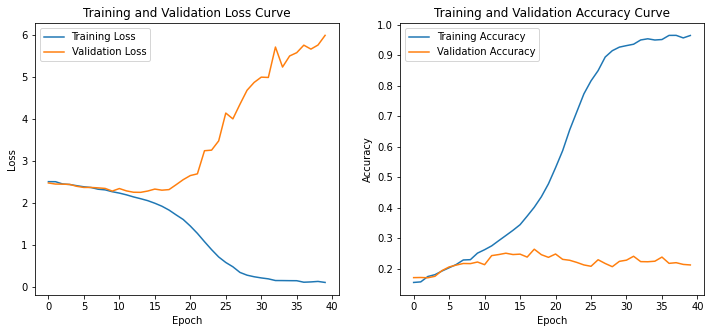

In [ ]:
#Plotting the Loss and Accuracy Curves
plot_model_curves(losses, accuracies, v_accuracies, v_losses)

**EVALUATE MODEL ON TEST SET**

TEST: Accuracy: 0.2141 | Loss: 5.9724 | Recall: 0.1926 | Precision: 0.2213 | F-score: 0.1920



<Figure size 576x576 with 0 Axes>

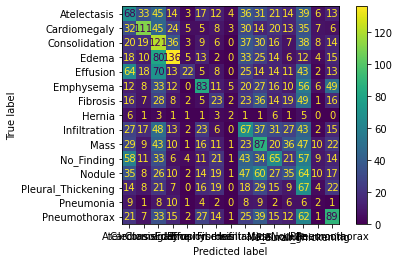

In [ ]:
#Evaluate Model on Test Set
evaluate_model(model, test_loader, test_indices, 'TEST', criterion, data_path, "ResNet18")

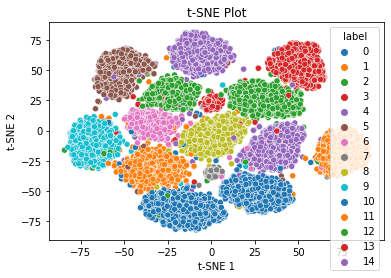

In [ ]:
#Obtain the TSNE Plot for the data
plot_TSNE(train_loader, device, model)

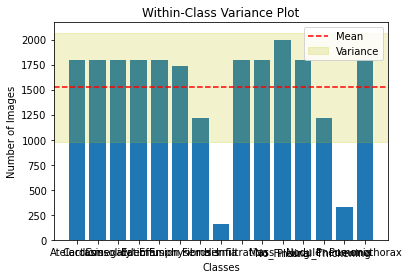

In [ ]:
# Get the class labels and the number of classes
plot_within_class_variance(dataset)

In [ ]:
def within_class_variance(dataset, model):
    # Set the model to evaluation mode
    model.load_state_dict(model['model_state_dict'])
    model.eval()
    # Get the feature vectors and labels for the dataset
    features = []
    labels = []
    for images, targets in train_loader:
        with torch.no_grad():
          images = images.to(device)
          targets = targets.to(device)
          output = model(images)
          features.append(output.cpu().numpy()[0])
          labels.append(targets.cpu().numpy()[0])
    features = np.array(features)
    labels = np.array(labels)
    
    # Calculate the within-class variance for each class
    class_variances = []
    for c in np.unique(labels):
        class_features = features[labels == c]
        class_mean = np.mean(class_features, axis=0)
        class_variance = np.mean(np.sum((class_features - class_mean)**2, axis=1))
        class_variances.append(class_variance)
    
    return class_variances

# Define the dataset and model
# Calculate the within-class variance
class_variances = within_class_variance(dataset, model)

# Plot the within-class variances for each class
plt.bar(np.arange(len(class_variances)), class_variances)
plt.xticks(np.arange(len(class_variances)), dataset.classes, rotation='vertical')
plt.ylabel('Within-class variance')
plt.show()

TypeError: 'ResNet' object is not subscriptable